#### Time Series Analysis of AirPassengers dataset using ARIMA AND SARIMAX

#### Import Libraries

In [84]:
import numpy as np
import pandas as pd 
from datetime import datetime as dt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6

import warnings
warnings.filterwarnings('ignore')


### Load Dataset 

In [19]:
data=pd.read_csv("AirPassengers.csv")
data.columns=["Month", "Passengers"]
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [20]:
data.dtypes

Month         object
Passengers     int64
dtype: object

In [21]:
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [22]:
data.shape

(144, 2)

In [23]:
#converting to datetime format 
data["Month"]=pd.to_datetime(data["Month"],format='%Y-%m')

In [24]:
data=data.set_index('Month')
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [25]:
data.isnull().sum()

Passengers    0
dtype: int64

### Step 1. Visualize the time series

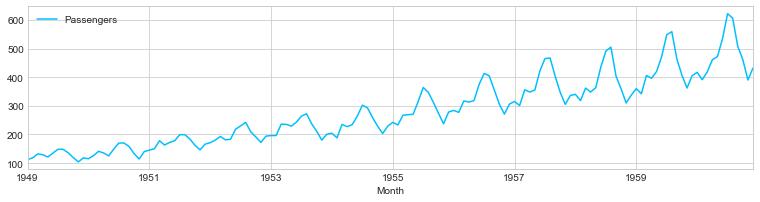

In [30]:
plt.style.use('seaborn-whitegrid')
data.plot(figsize=(13,3), color='deepskyblue')
plt.show()

**Insights**
- Series has upword trend


<AxesSubplot:ylabel='Density'>

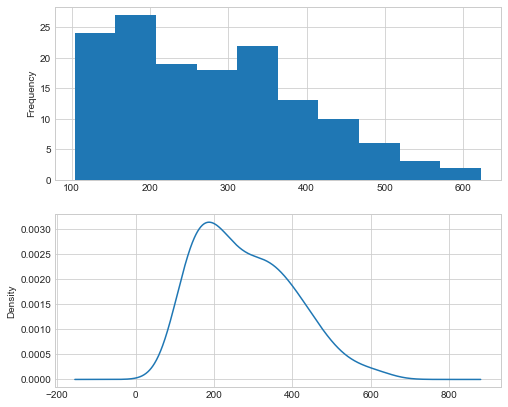

In [34]:
plt.figure(figsize=(8,7))
plt.subplot(211)
data.Passengers.plot(kind='hist')
plt.subplot(212)
data.Passengers.plot(kind='kde')

**Insights**
* The distribution is not perfectly Gaussian (normal distribution).
* The distribution is right shifted.
* Transformations might be useful prior to modeling.

<AxesSubplot:xlabel='Month', ylabel='Passengers'>

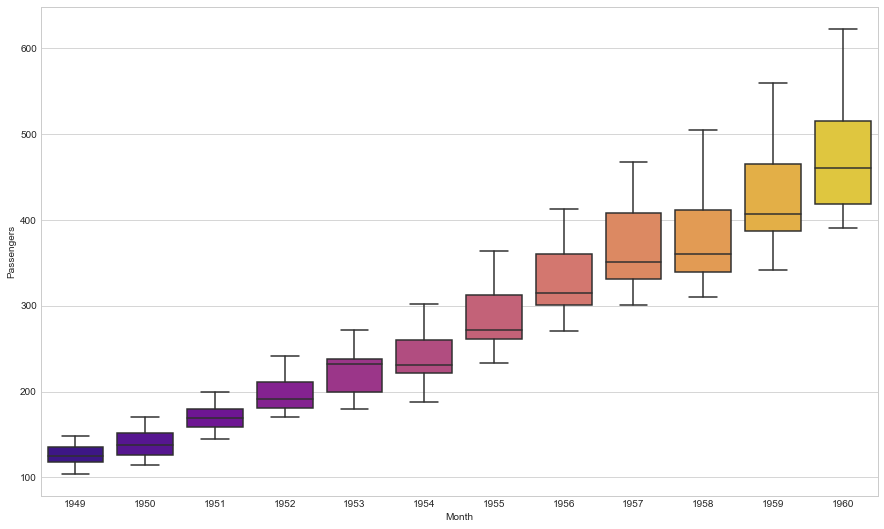

In [35]:
plt.figure(figsize=(15,9))
sns.boxplot(data.Passengers.index.year, data.Passengers, palette='plasma')

**Insights**
* Median values across years confirms an upwards trend
* Steady increase in the spread, or middle 50% of the data (boxes) over time
* A model considering seasonality might work well

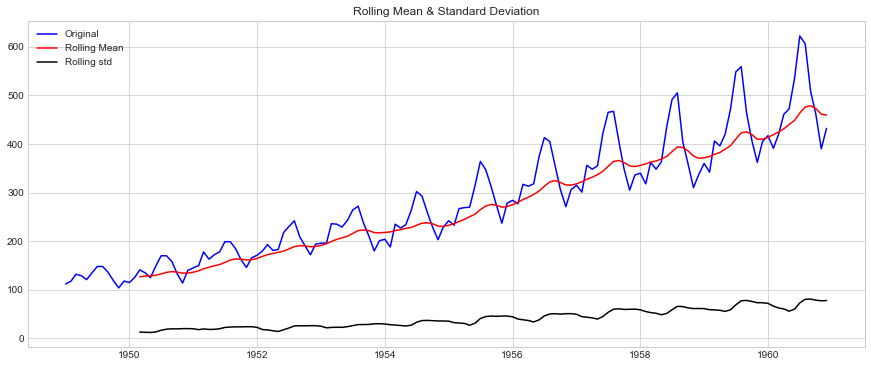

In [36]:
#Determine Rolling Statistics
rolmean=data.rolling(window=15).mean()
rolstd=data.rolling(window=15).std()

#plot Rolling Statistics
orig=plt.plot(data, color='blue', label='Original')
mean=plt.plot(rolmean, color='red', label='Rolling Mean')
mean=plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Insight**
* We observe that the moving(rolling) mean and moving std dev are not constant with respect to time (both are showing increasing trends). Ideal case moving avg., moving std dev must be constant.
* The time series is not stationary

### Step 2.  Augumented Dickey-fuller test

- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).

    * Null Hypothesis (H0) that the time series is not stationary and 
    * Alternate hypothesis (H1) that the time series is stationary. 

- The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the 'Test Statistic' is less than the 'Critical Value', we can reject the null hypothesis and say that the series is stationary.

In [40]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(data.Passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


- critical value= 5% i.e 0.05
- P value 0.99
- We accept the null hypothesis that the time series is not stationary at p value of 0.99.

In [41]:
# stationarity check function
# H0 - It is non stationary
# H1 - It is stationary (Alternative Hypothesis)
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### there are multiple ways to make time series stationary

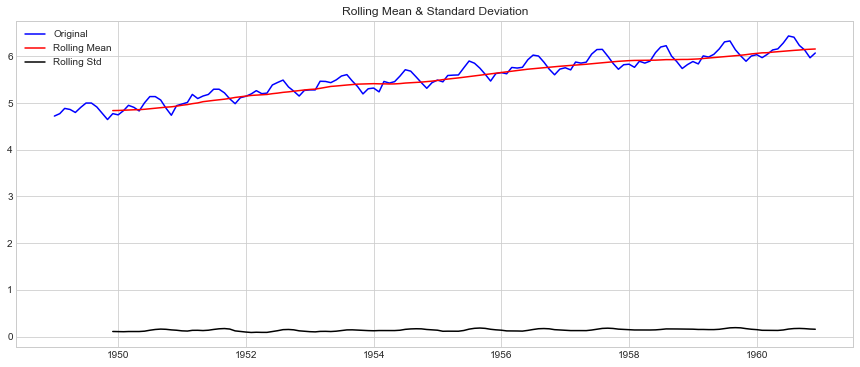

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [43]:
#1.Log transformation
ts_log=np.log(data)
test_stationarity(ts_log)

- P value > 0.05
- not making series stationary

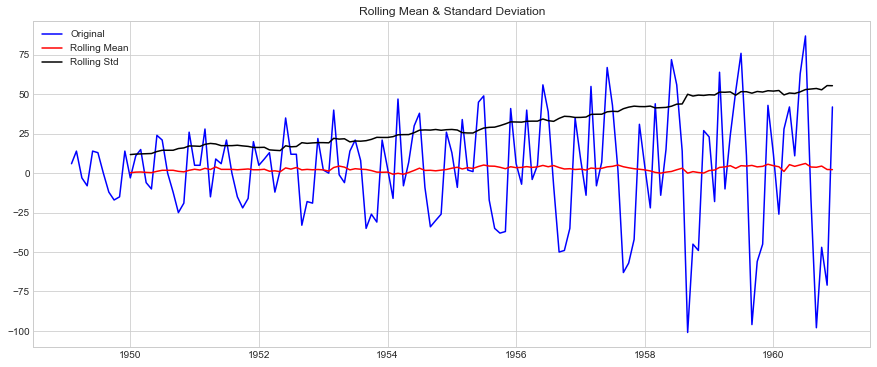

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [48]:
#diffrencing
ts_diff=data-data.shift(1)
ts_diff.dropna(inplace=True) # drop null value
test_stationarity(ts_diff)

- At p value closer to 0.05,  but moving mean & moving std is Not constant hence, null hypothesis is Accepted. therefore The series is Not stationary

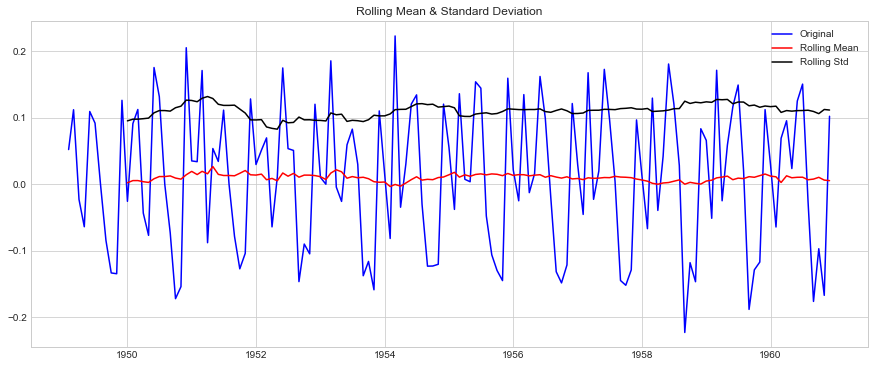

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [49]:
#log Diffrenecing
ts_log_diff=ts_log-ts_log.shift(1)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

* At p value closer to 0.05, and moving mean & moving std is also constant hence, null hypothesis is rejected. i.e Alternative Hypothesis is accepted, therefore The series is stationary

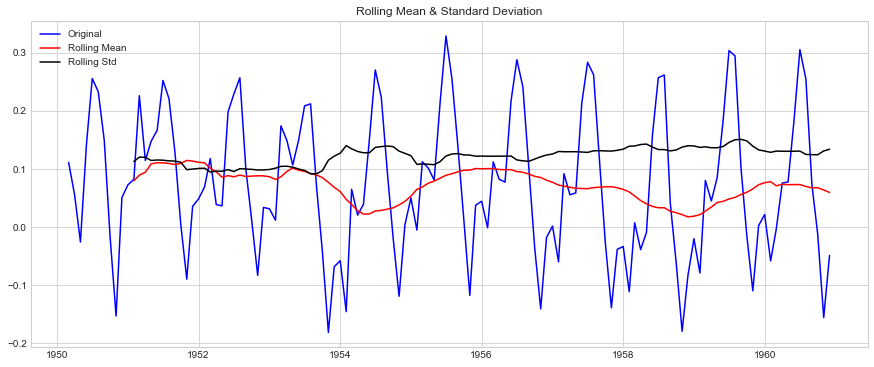

Results of Dickey-Fuller Test:
Test Statistic                  -3.079301
p-value                          0.028123
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


In [51]:
#get the diffrence bet moving avg and actual no of passenger
mvag=ts_log.rolling(window=15).mean()
ts_log_mv_diff=ts_log-mvag
ts_log_mv_diff.dropna(inplace=True)
test_stationarity(ts_log_mv_diff)

- the time series now stationary

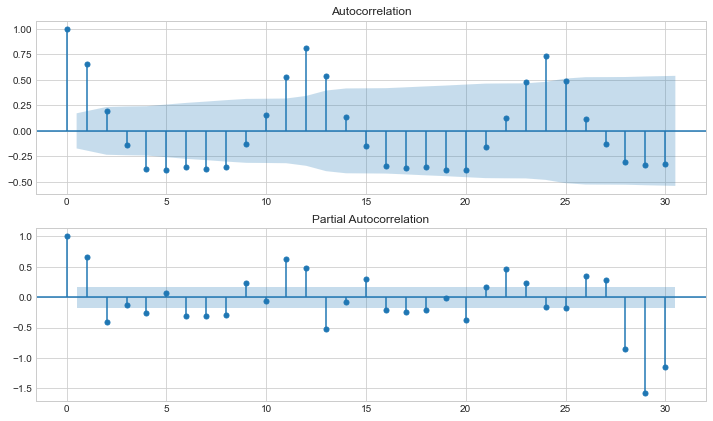

In [52]:
#ACF, PACF, p,d,q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize = (12,7))
plt.subplot(211)
plot_acf(ts_log_mv_diff, ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(ts_log_mv_diff, ax=plt.gca(),lags=30)
plt.show()

* The ACF curve crosses the upper confidence value when the lag value is between 0 and 1. Thus, optimal value of q in the ARIMA model must be 0 or 1
* The PACF curve drops to 0 between lag values 1 and 2. Thus, optimal value of p in the ARIMA model is 1 or 2.

### Step 3. ARIMA Model

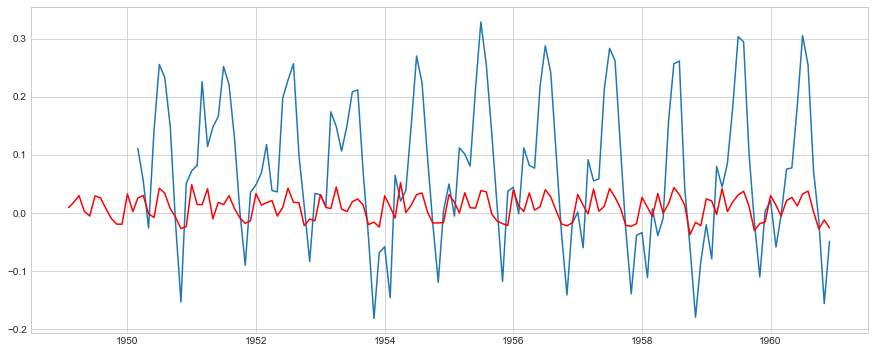

In [53]:
model=ARIMA(ts_log, order=(1,1,0))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color="red")

Text(0.5, 1.0, 'RMSE: nan')

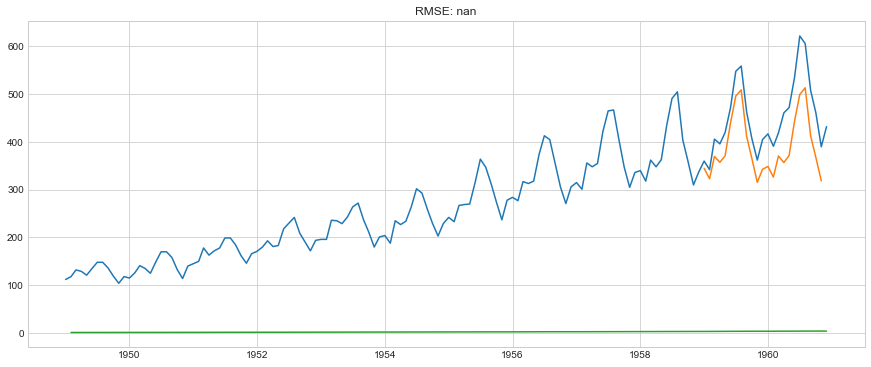

In [82]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
rmse=np.sqrt(sum((predictions_ARIMA-data["Passengers"])**2)/len(data["Passengers"]))
plt.title('RMSE: %.4f'% rmse)

In [56]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(data,order=(1,1,0))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -698.736
Method:                       css-mle   S.D. of innovations             32.040
Date:                Mon, 20 Mar 2023   AIC                           1403.473
Time:                        02:43:03   BIC                           1412.361
Sample:                    02-01-1949   HQIC                          1407.085
                         - 12-01-1960                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3698      3.837      0.618      0.537      -5.150       9.890
ar.L1.D.Passengers     0.3038      0.080      3.810      0.000       0.148       0.460
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.2922           +0.0000j            3.2922            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Month'>

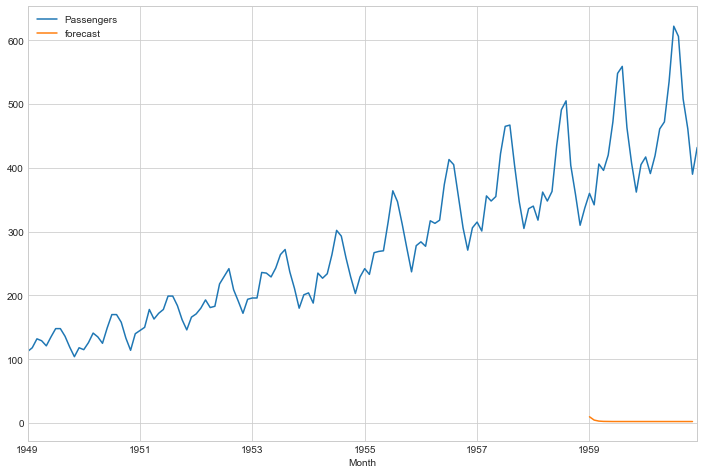

In [63]:
data['forecast']=model_fit.predict(start=120,end=142,dynamic=True)
data[['Passengers','forecast']].plot(figsize=(12,8))

**Note:** 

- ARIMA model not work well on Seasonal Dataset 
- SARIMAX(seasonal ARIMA) works well on seasonal dataset


### Step 4. SARIMAX Model

<AxesSubplot:xlabel='Month'>

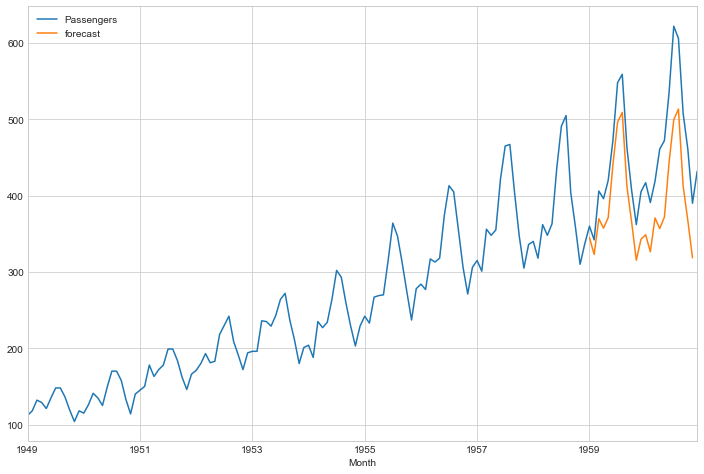

In [64]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['Passengers'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data['forecast']=results.predict(start=120,end=142,dynamic=True)
data[['Passengers','forecast']].plot(figsize=(12,8))

<AxesSubplot:>

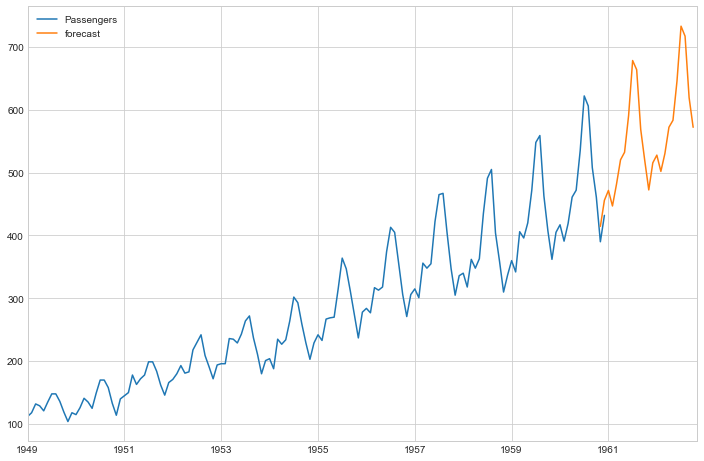

In [72]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

future_datest_df.tail()

future_df=pd.concat([data,future_datest_df])

future_df['forecast'] = results.predict(start = 142, end = 165, dynamic= True)
future_df[['Passengers', 'forecast']].plot(figsize=(12, 8))

### End